In [1]:
import torch
import pickle

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from dynamic_bVAE.models import dynamicVAE32, beta_from_normalized_beta, build_tridiag
from data.dspritesbT import dSpriteBackgroundDatasetTime

In [2]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.1']
['betanorm = 0.005 / beta = 0.6']
['betanorm = 0.030 / beta = 3.1']
['betanorm = 0.166 / beta = 17.0']
['betanorm = 0.910 / beta = 93.2']
['betanorm = 5.000 / beta = 512.0']


In [3]:
vae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = 'trained/dynamicvae32_nlatent=10_betanorm=%s_dspritesT_circle_last_500K' % (beta_norm_str)
    trainstatspath = 'trained/dynamicvae32_nlatent=10_betanorm=%s_dspritesT_circle_500K.pkl' % (beta_norm_str)
    
    vae.append(dynamicVAE32(n_latent = 10))
#     checkpoint = torch.load(trainedpath)
#     vae[ii].load_state_dict(checkpoint['model_states']['net'])
# 
#     training_stats.append(pickle.load(open(trainstatspath, 'rb')))

In [4]:
vae[0]

dynamicVAE32(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_enc_mu): Linear(in_features=640, out_features=100, bias=True)
  (fc_enc_D): Linear(in_features=640, out_features=1000, bias=True)
  (fc_enc_B): Linear(in_features=640, out_features=900, bias=True)
  (fc_dec): Linear(in_features=100, out_features=640, bias=True)
  (convT5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (c

In [5]:
dt = dSpriteBackgroundDatasetTime(transform=transforms.Resize((32,32)),
                                   shapetype='circle',data_dir='data/dsprites-dataset/')

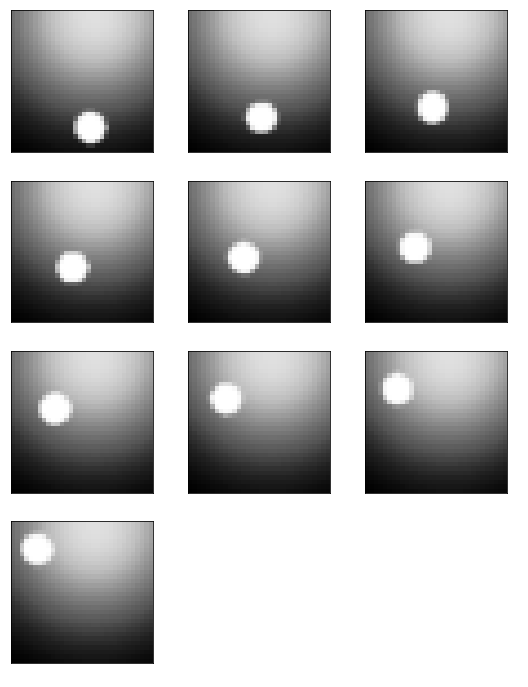

In [6]:
from data.dspritesb import show_images_grid
show_images_grid(dt[3][0])

In [7]:
dt[3][0].shape

torch.Size([10, 1, 32, 32])

In [8]:
vae[0].n_frames

10

In [9]:
x = dt[3][0]#.permute(1,2,3,0).unsqueeze(0)
x.shape
# vae[0].encode(dt[3][0])

torch.Size([10, 1, 32, 32])

torch.Size([25, 10, 1, 32, 32])


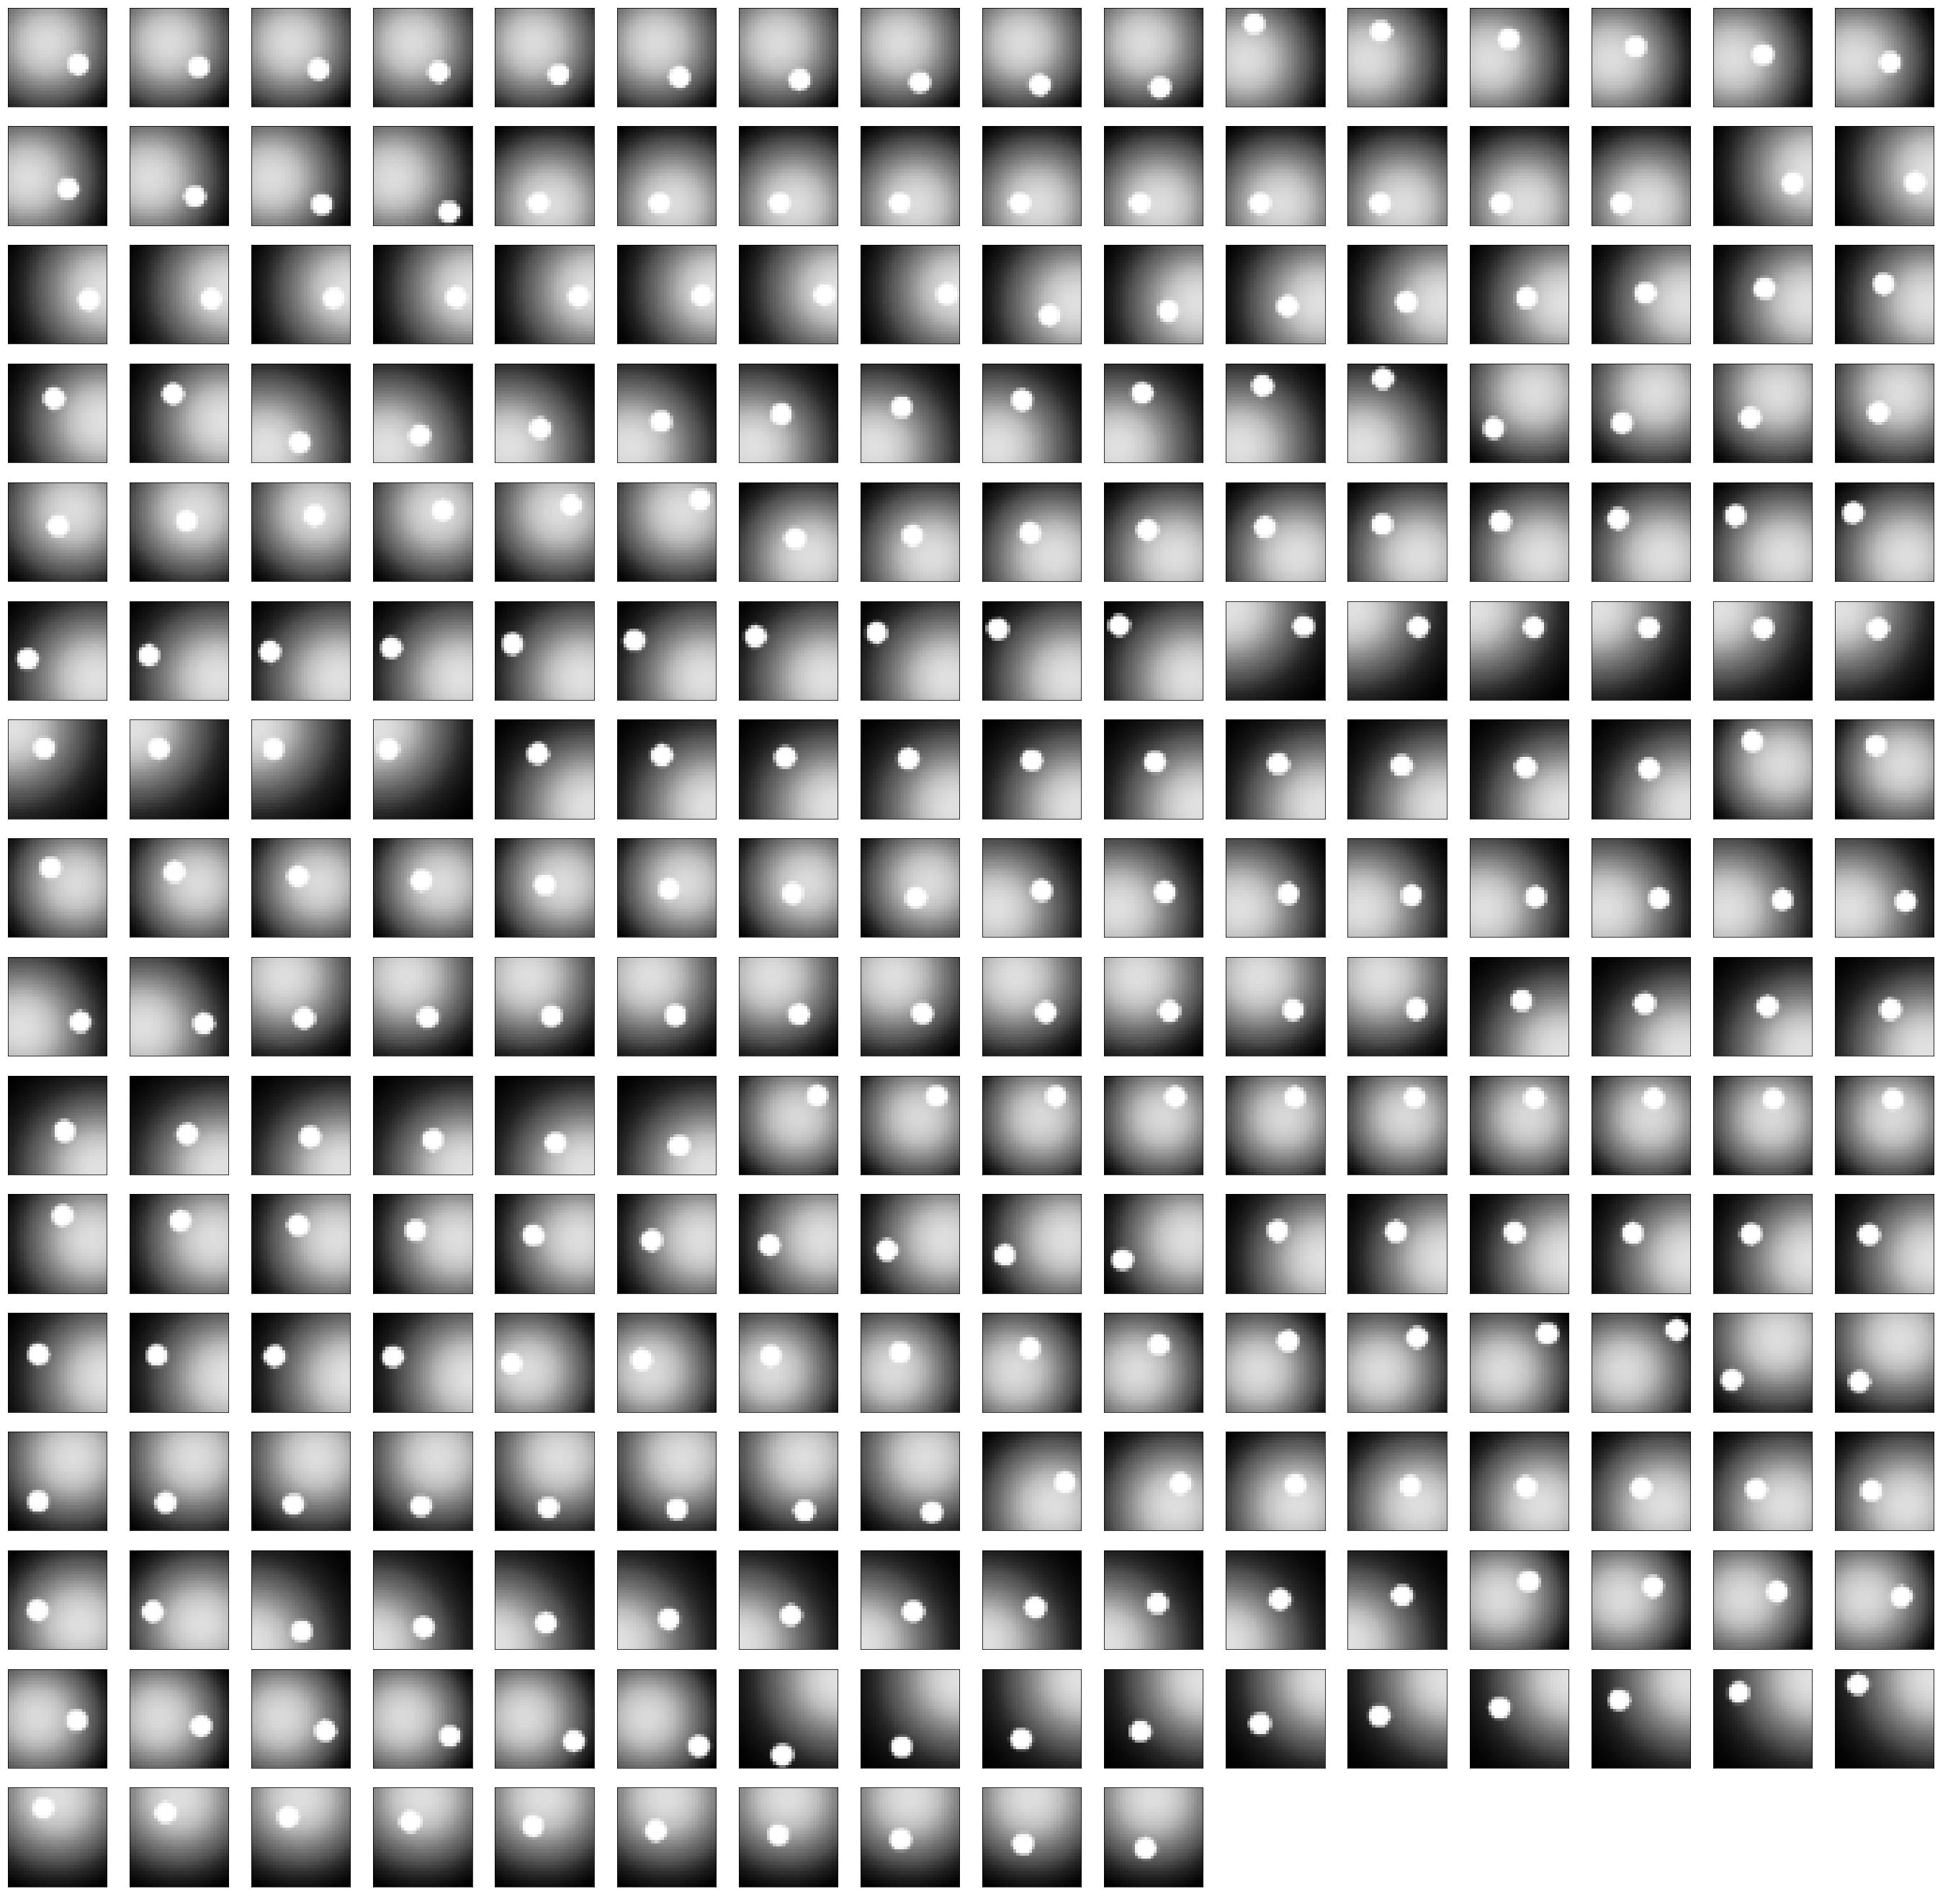

In [10]:
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dt, batch_size=25,shuffle=True, num_workers=4)
for i,[samples,latents] in enumerate(dataloader):
    print(samples.shape)
    show_images_grid(samples.view(25*10,1,32,32))
    break
x = samples

In [11]:
x.view(vae[0].n_frames*x.size(0),1,32,32).shape

torch.Size([250, 1, 32, 32])

In [12]:
x1=vae[0].conv1(x.view(vae[0].n_frames*x.size(0),1,32,32))
x1.shape
x5=vae[0].conv5(vae[0].conv4(vae[0].conv3(vae[0].conv2(x1))))
x5.shape

torch.Size([250, 64, 1, 1])

In [13]:
x5.view(-1,vae[0].n_latent).shape

torch.Size([1600, 10])

In [14]:
vae[0].fc_enc_mu(x5.view(-1,vae[0].n_frames*64)).shape

torch.Size([25, 100])

In [15]:
vae[0].fc_enc_D(x5.view(-1,vae[0].n_frames*64)).shape

torch.Size([25, 1000])

In [16]:
vae[0].fc_enc_B(x5.view(-1,vae[0].n_frames*64)).shape

torch.Size([25, 900])

In [17]:
mu, D, B = vae[0].encode(x)

p = D.shape[1] - B.shape[1]
t = int(D.shape[1]/p)
mu.shape,p,t,int(p**0.5)

(torch.Size([25, 100]), 100, 10, 10)

In [18]:
P = build_tridiag(D,B,alpha=0.5)
P.shape

torch.Size([25, 100, 100])

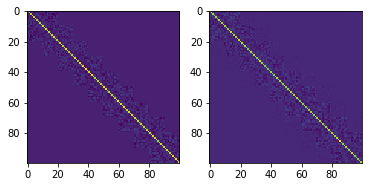

In [19]:
plt.subplot(1,2,1)
plt.imshow(P[0,:,:].detach().numpy())
plt.subplot(1,2,2)
plt.imshow(torch.inverse(P[0,:,:]).detach().numpy())

In [20]:
# torch.cholesky(torch.inverse(P))

In [21]:
z, covariance_mat, precision_mat = vae[0].reparametrize(mu, D, B, alpha=0.5)
z.shape, covariance_mat.shape, precision_mat.shape

(torch.Size([25, 100]), torch.Size([25, 100, 100]), torch.Size([25, 100, 100]))

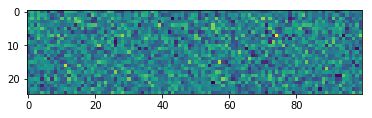

In [29]:
plt.imshow(z)

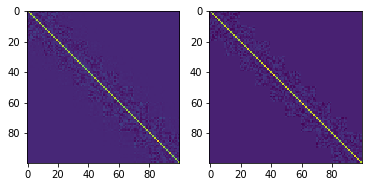

In [22]:
plt.subplot(1,2,1)
plt.imshow(covariance_mat[0,:,:].detach().numpy())
plt.subplot(1,2,2)
plt.imshow(precision_mat[0,:,:].detach().numpy())

In [23]:
x_recon = vae[0].decode(z)
x_recon.shape

torch.Size([250, 1, 32, 32])

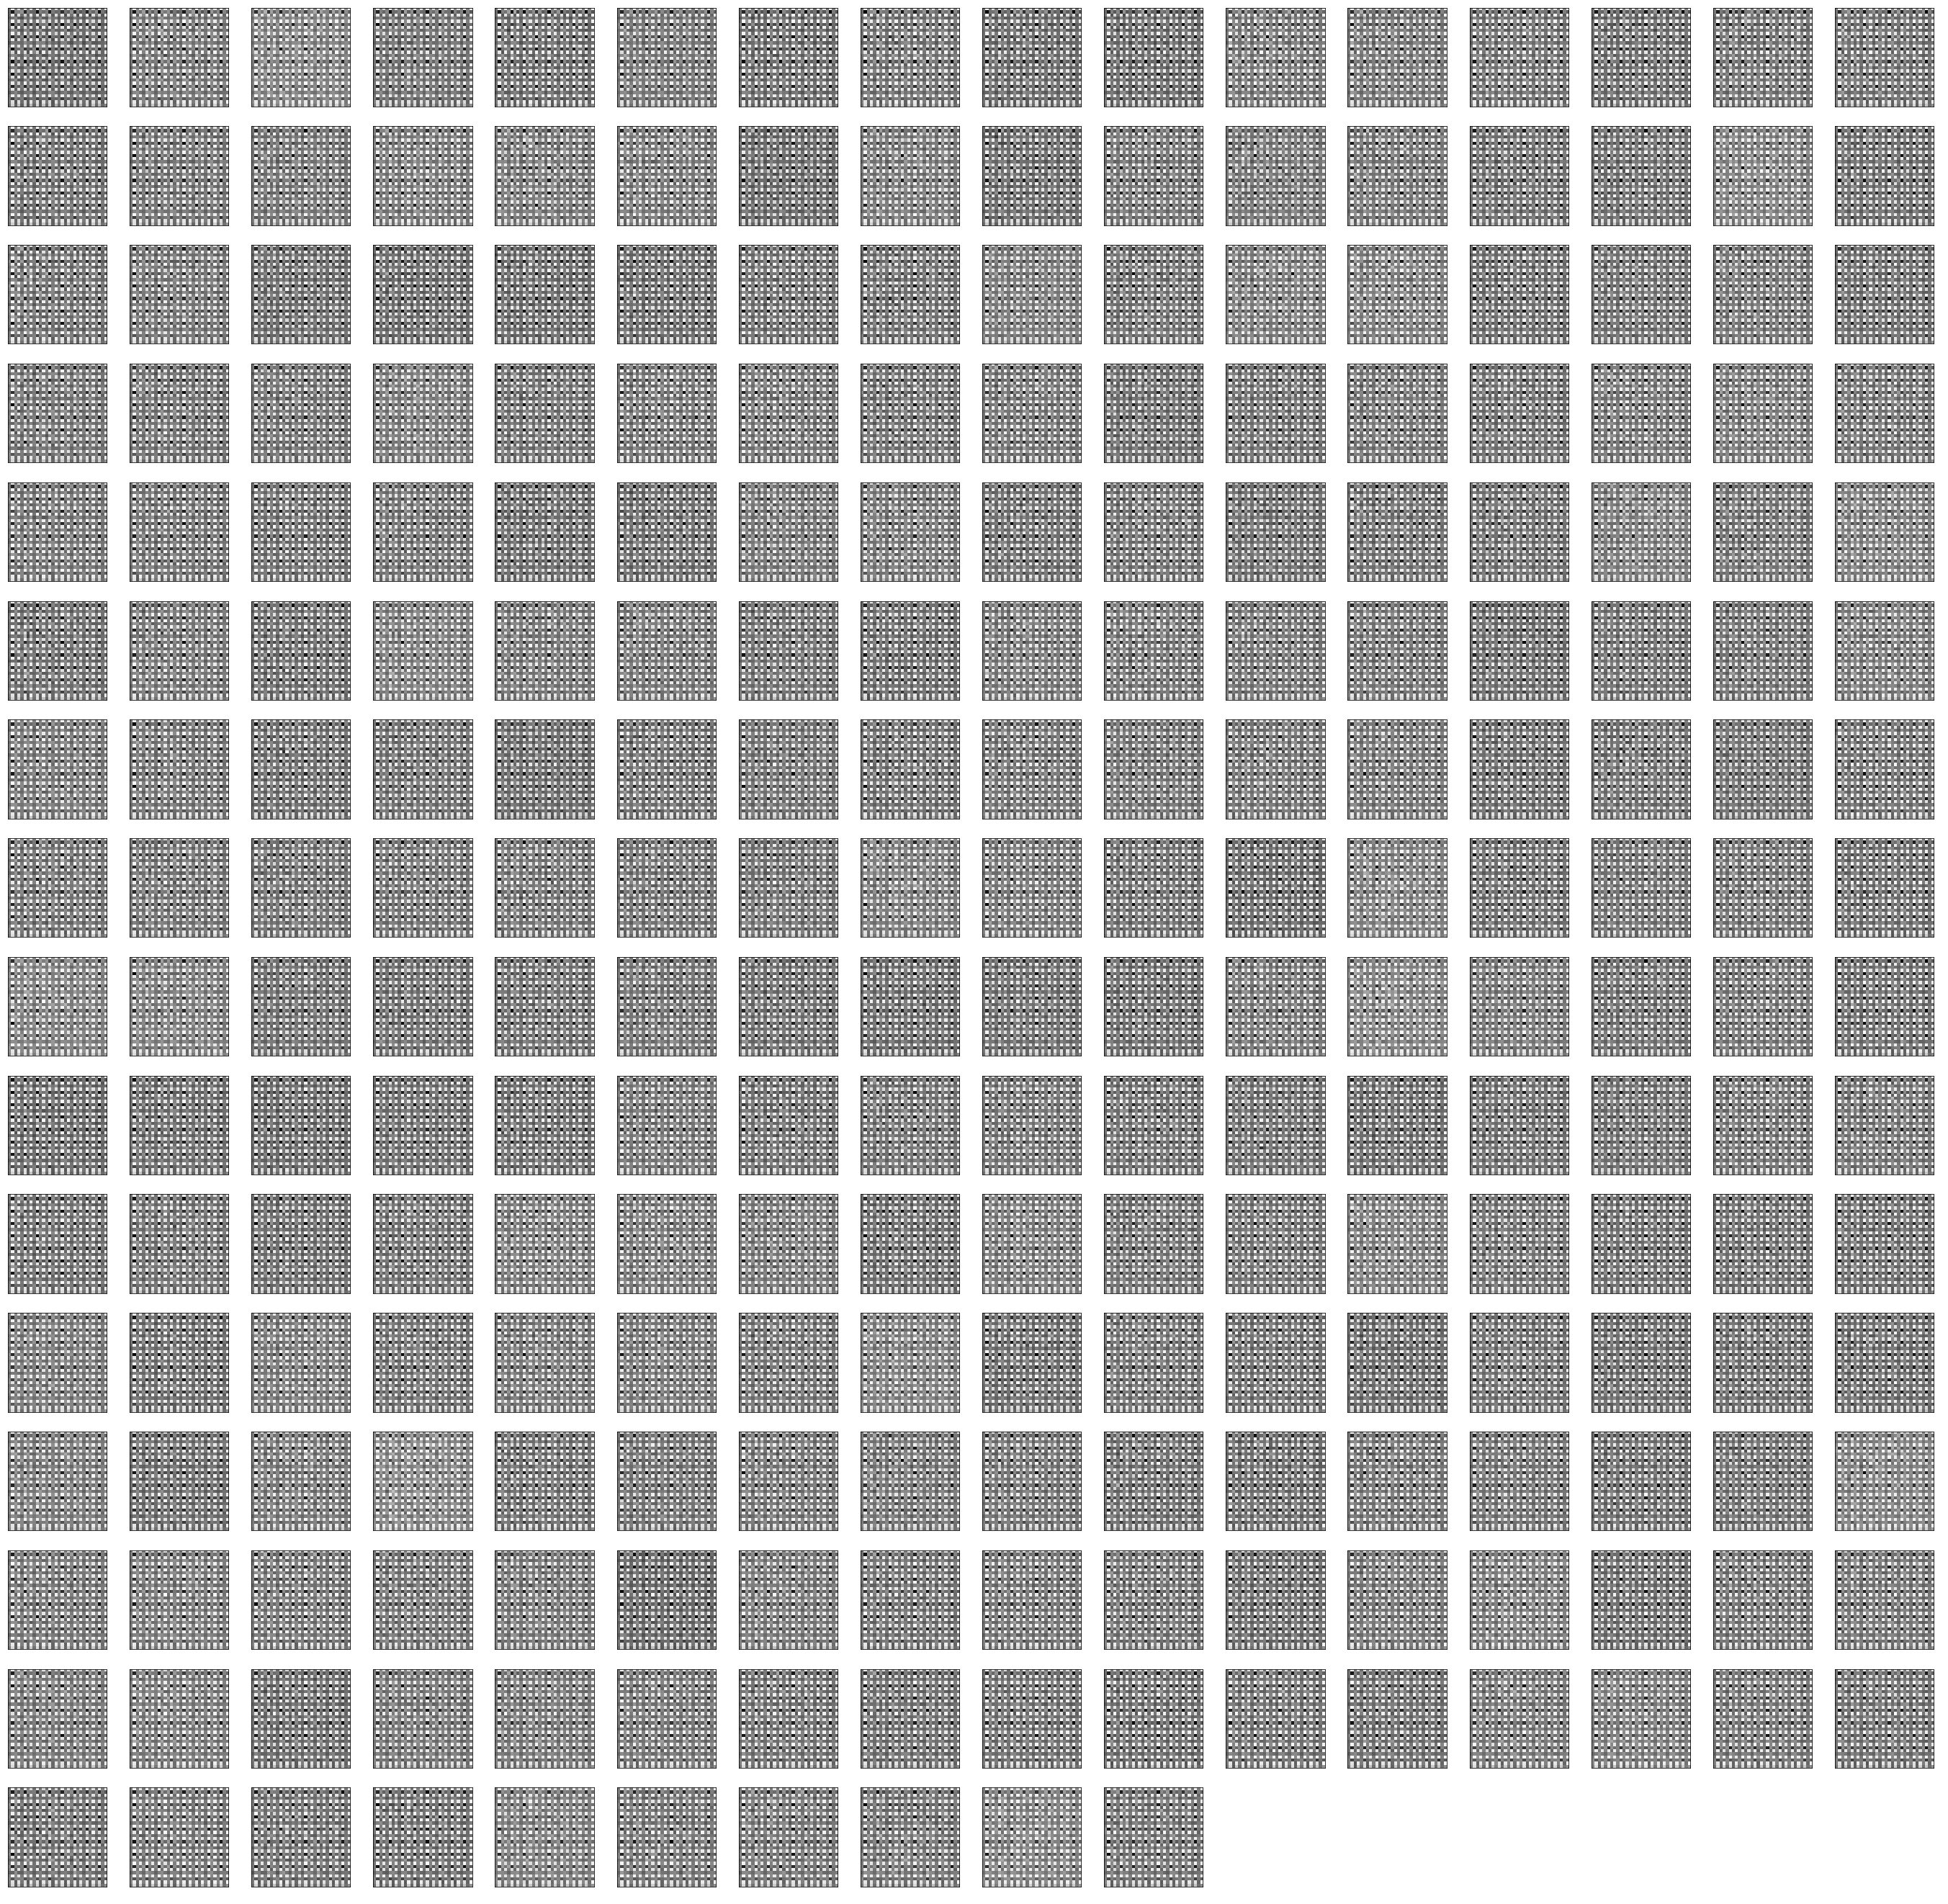

In [24]:
show_images_grid(x_recon.detach())

In [25]:
from models import reconstruction_loss
recon_loss = reconstruction_loss(x, x_recon, distribution='gaussian')
recon_loss

tensor(641.4962, grad_fn=<DivBackward0>)

In [26]:
from models import kl_divergence
total_kld, dimension_wise_kld, mean_kld = kl_divergence(mu, covariance_mat, precision_mat)
total_kld, dimension_wise_kld, mean_kld

torch.Size([25, 100])


(tensor(92314.6406, grad_fn=<MeanBackward2>),
 tensor(3692.5857, grad_fn=<MeanBackward2>),
 tensor(3692.5857, grad_fn=<MeanBackward2>))

In [28]:
k = mu.size(0)
klds = 0.5*( torch.trace(covariance_mat) + torch.dot(mu,mu) - k * torch.logdet(precision_mat) )
klds

tensor(3744.8938, grad_fn=<MulBackward0>)